In [4]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer
from datetime import datetime
from sklearn_extra.cluster import KMedoids
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean
import importlib
import clustering_processing as cp, preprocessing as prep, cluster_grid
import somoclu

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data_cleaned')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned.csv'))  
output_directory = os.path.join(base_directory, 'figures_for_paper')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

STEP 1: Create unnormalized combined dataframe of all sites annual profiles
STEP 2: Create low consumption dict (keys are each date, values are list of sites which have low consumption profile on that day)

In [5]:

importlib.reload(prep)
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')
combined_df_unnormalized = prep.create_combined_df_UNNORMALIZED(cleaned_data_directory, date_range)

In [6]:
# Pre-bin the "baseline" group with inputted thresholds for low consumption and create the dictionary for low consumption values.
# values were justified in other_investigations/parameter_sweep
importlib.reload(prep)
min_cons = 0.015 # Threshold is standby power is 3W = 0.015 kwh per half hour
low_consumption_dict = prep.create_low_consumption_dict(combined_df_unnormalized, min_cons=min_cons)


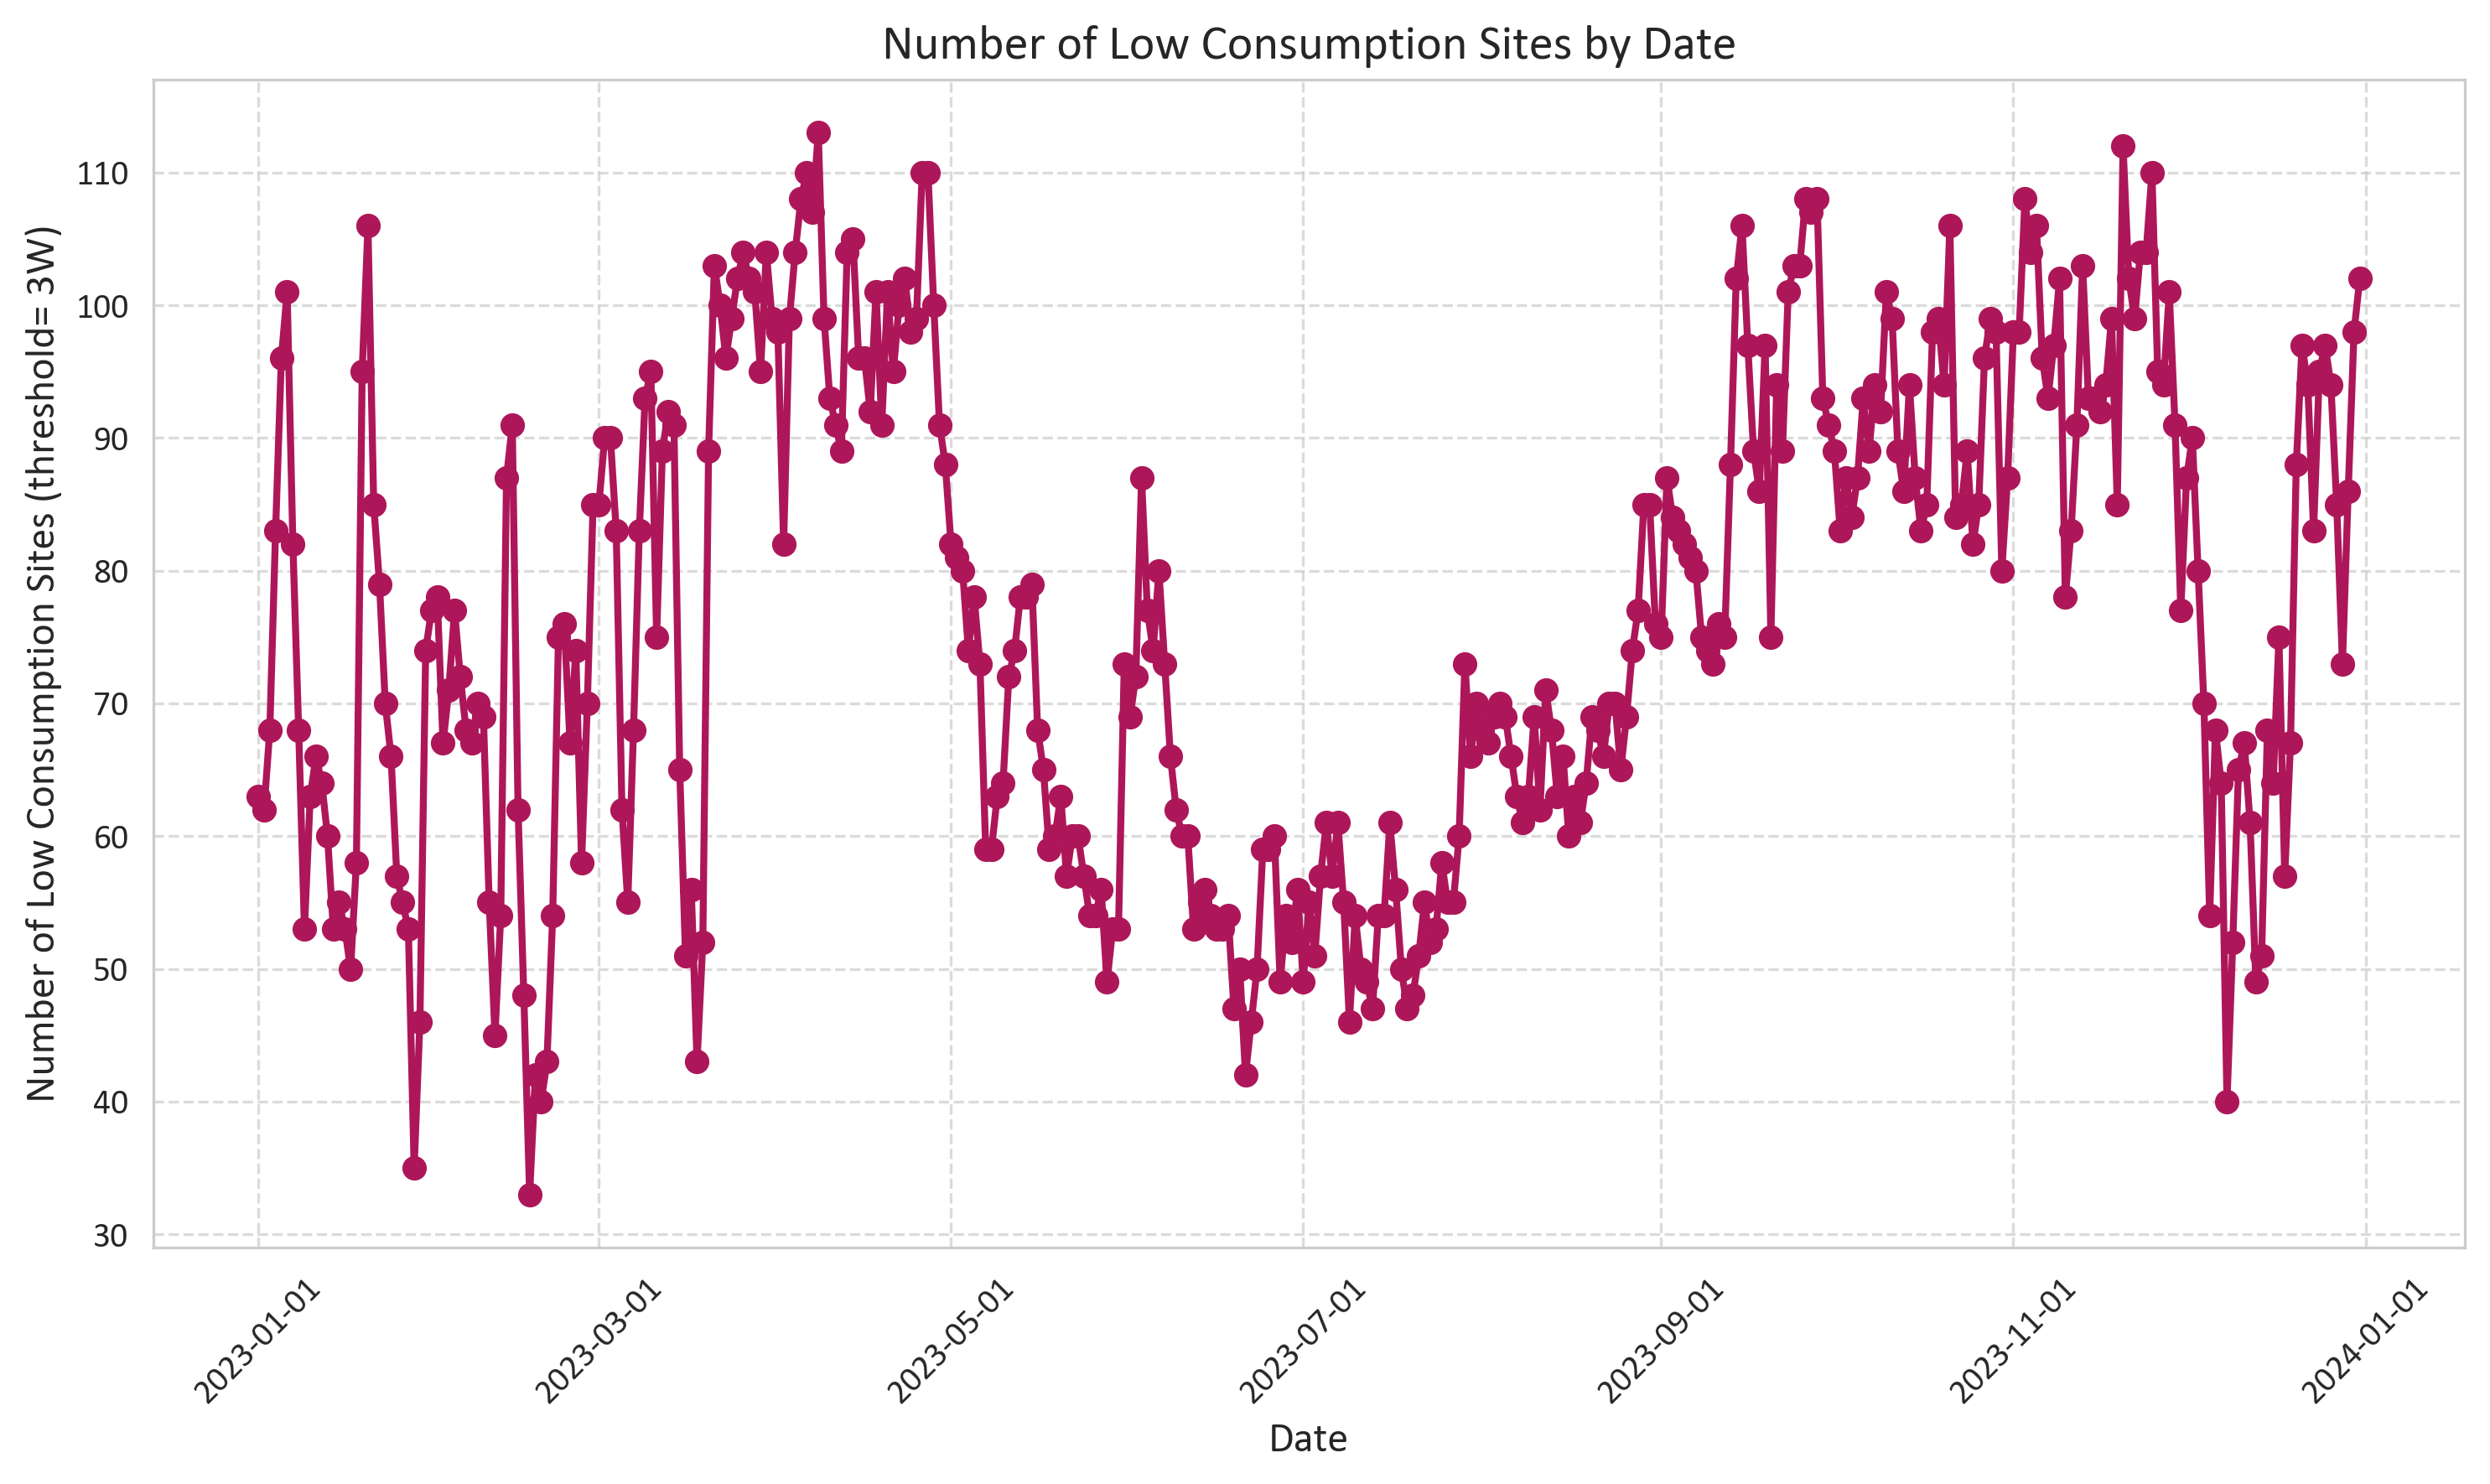

In [7]:
# Visualize Low Consumptions by Date 
# Extract dates and lengths into separate lists
dates = list(low_consumption_dict.keys())
num_sites = [len(sites) for sites in low_consumption_dict.values()]

# Set preferred style, font, and color palette
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Calibri"

# Create the plot
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(dates, num_sites, marker='o', linestyle='-', linewidth=2, color=sns.color_palette("rocket")[2])

# Customize the plot
plt.title('Number of Low Consumption Sites by Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Low Consumption Sites (threshold= 3W)', fontsize=12)

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()


# save figure to output directory
plt.savefig(os.path.join(output_directory, 'low_consumption_sites_by_date.png'), dpi=300, format = "png")


# Show the plot
plt.show()

In [8]:
# Create min-max scaled combined dataframe with half-hourly timestamps from 01/01/2023-12/31/2023 as rows and site IDs as columns
# Site IDs with no air con or net load data were removed, Site IDs which had 
importlib.reload(prep)

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

#combined_df = prep.create_combined_df(cleaned_data_directory, date_range)
training_df, testing_df = prep.create_train_test_combined_df(cleaned_data_directory, date_range)


In [ ]:


def find_filtered_date_df(X, low_consumption_dict, date, feature_weights):
    
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 0.7,
            'summary_stats': 0.3
        }
    if date in low_consumption_dict:
        sites_to_remove = low_consumption_dict[date]
        # Find which sites actually exist in X
        sites_found = [site for site in sites_to_remove if site in X.columns]
        
        if sites_found:
            # print(f"Removing {len(sites_found)} low consumption sites for date {date}:")
            # print(f"Sites removed: {', '.join(sites_found)}")
            
            # Remove the sites
            X_filtered = X.drop(columns=sites_found)
        else:
            print(f"No sites to remove for date {date}")
            return X
    else:
        print(f"No low consumption sites listed for date {date}")


    #transpose X
    profiles = X_filtered
    print(X_filtered.shape)

    features_list = []
    # iterate through each row (profile) in the dataframe
    for profile_name in profiles.columns:
        profile = profiles[profile_name].values
        features = cp.calculate_time_series_features(profile)
        features_list.append(features)
    
    # Convert features to array and scale
    features_df = pd.DataFrame(features_list, index=profiles.columns)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_df)

    X_values = profiles.T.values
    # Combine scaled data using weights
    X_filtered_with_features = np.hstack([
        X_values * feature_weights['raw_profile'],
        features_scaled * feature_weights['summary_stats']
    ])

    X_filtered_with_features = pd.DataFrame(X_filtered_with_features.T, columns=profiles.columns)
    X_filtered = X_filtered.T
    #print("SAMPLE OF X FILTERED")
    #print(X_filtered.head(2))
    X_filtered_with_features = X_filtered_with_features.T
    #print("Sample of X filtered with features")
    #print(X_filtered_with_features.head(2))
    return X_filtered, X_filtered_with_features

def evaluate_clusters_kmeans(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Input: training_df that's been modified to drop any site IDs with NA, 
    min cluster and max cluster are the constraints on maximum number of clusters
    feature weights: weight given to summary statistics vs. raw profile

    Output: silhouette scores, dbi scores, mia scores, combined indices for the selected date for range of number of clusters
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=42) 
            labels = kmeans.fit_predict(X_filtered_with_features) # creates an array like (122,) with cluster number for each indexed site
            # Calculate scores
            sil_score = silhouette_score(X_filtered_with_features, labels)
            dbi_score = davies_bouldin_score(X_filtered_with_features, labels)
            mia_score = cluster_grid.mean_index_adequacy(X_filtered_with_features, labels)
            combined_index = (dbi_score * mia_score) / sil_score if sil_score != 0 else float('inf')

            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)

        except Exception as e:
            print(f"Error with {n_clusters} KMeans clusters: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num

def evaluate_clusters_kmedoids(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Same as evaluate_clusters_kmeans but using KMedoids instead
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
            labels = kmedoids.fit_predict(X_filtered_with_features)
            # Calculate scores
            sil_score = silhouette_score(X_filtered_with_features, labels)
            dbi_score = davies_bouldin_score(X_filtered_with_features, labels)
            mia_score = cluster_grid.mean_index_adequacy(X_filtered_with_features, labels)
            combined_index = (dbi_score * mia_score) / sil_score if sil_score != 0 else float('inf')

            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)

        except Exception as e:
            print(f"Error with {n_clusters} KMedoids clusters: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num

def optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters=4, max_clusters=8): 
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    day_df_cleaned = day_df_cleaned.interpolate(method='linear') 
    if day_df_cleaned.shape[1] <= 1: 
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.") 
        return None 

    # KMeans clustering 
    kmeans_silhouette, kmeans_dbi, kmeans_mia, kmeans_combined, sample_num = evaluate_clusters_kmeans(
        day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    ) 
    
    # KMedoids clustering
    kmedoids_silhouette, kmedoids_dbi, kmedoids_mia, kmedoids_combined, _ = evaluate_clusters_kmedoids(
        day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    
    # Find optimal number of clusters for each method
    kmeans_optimal_idx = np.nanargmin(kmeans_combined) if not all(np.isnan(kmeans_combined)) else -1
    kmedoids_optimal_idx = np.nanargmin(kmedoids_combined) if not all(np.isnan(kmedoids_combined)) else -1
    
    # If both methods failed, return None
    if kmeans_optimal_idx == -1 and kmedoids_optimal_idx == -1:
        print(f"Both KMeans and KMedoids clustering failed for {date}")
        return None
    
    # Determine the optimal method and clusters
    if kmeans_optimal_idx == -1:
        optimal_method = "KMedoids"
        optimal_clusters = kmedoids_optimal_idx + min_clusters
        optimal_score = kmedoids_combined[kmedoids_optimal_idx]
        optimal_silhouette = kmedoids_silhouette[kmedoids_optimal_idx]
        optimal_dbi = kmedoids_dbi[kmedoids_optimal_idx]
        optimal_mia = kmedoids_mia[kmedoids_optimal_idx]
    elif kmedoids_optimal_idx == -1:
        optimal_method = "KMeans"
        optimal_clusters = kmeans_optimal_idx + min_clusters
        optimal_score = kmeans_combined[kmeans_optimal_idx]
        optimal_silhouette = kmeans_silhouette[kmeans_optimal_idx]
        optimal_dbi = kmeans_dbi[kmeans_optimal_idx]
        optimal_mia = kmeans_mia[kmeans_optimal_idx]
    else:
        # Compare the best scores from each method
        kmeans_best_score = kmeans_combined[kmeans_optimal_idx]
        kmedoids_best_score = kmedoids_combined[kmedoids_optimal_idx]
        
        if np.isnan(kmeans_best_score) or (not np.isnan(kmedoids_best_score) and kmedoids_best_score < kmeans_best_score):
            optimal_method = "KMedoids"
            optimal_clusters = kmedoids_optimal_idx + min_clusters
            optimal_score = kmedoids_combined[kmedoids_optimal_idx]
            optimal_silhouette = kmedoids_silhouette[kmedoids_optimal_idx]
            optimal_dbi = kmedoids_dbi[kmedoids_optimal_idx]
            optimal_mia = kmedoids_mia[kmedoids_optimal_idx]
        else:
            optimal_method = "KMeans"
            optimal_clusters = kmeans_optimal_idx + min_clusters
            optimal_score = kmeans_combined[kmeans_optimal_idx]
            optimal_silhouette = kmeans_silhouette[kmeans_optimal_idx]
            optimal_dbi = kmeans_dbi[kmeans_optimal_idx]
            optimal_mia = kmeans_mia[kmeans_optimal_idx]
    
    return (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi, optimal_mia, sample_num, optimal_method)

def main(df, low_consumption_dict): 
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    daily_results = [] 
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        print(f"Processing date: {date}, data shape: {day_df.shape}") 
        optimal_result = optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters=4, max_clusters=8) 
        if optimal_result is not None: 
            (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi, optimal_mia, sample_num, optimal_method) = optimal_result 
            daily_results.append({ 
                'Date': date, 
                'OptimalClusters': optimal_clusters, 
                'Combined_Index': optimal_score, 
                'Silhouette': optimal_silhouette, 
                'DBI': optimal_dbi, 
                'MIA': optimal_mia,
                'Total Number of Households': sample_num,
                'OptimalMethod': optimal_method
            }) 
        else: 
            daily_results.append({ 
                'Date': date, 
                'OptimalClusters': None,
                'Combined_Index': None,
                'Silhouette': None, 
                'DBI': None, 
                'MIA': None, 
                'Total Number of Households': None,
                'OptimalMethod': None
            }) 

    results_df = pd.DataFrame(daily_results) 
    results_df['Date'] = pd.to_datetime(results_df['Date']) 
    results_df = results_df.sort_values('Date') 
    print("Daily optimal clusters comparison processed.") 
    return results_df

# Example usage 
optimal_clusters_by_date = main(training_df, low_consumption_dict) 
print(optimal_clusters_by_date.head())

In [28]:
if not os.path.exists(os.path.join(base_directory, 'optimal_clusters_by_date.csv')):
    optimal_clusters_by_date.to_csv((os.path.join(base_directory, 'optimal_clusters_by_date.csv')), index=False)
    print(f'File written: optimal_clusters_by_date.csv')
else:
    print('File already exists!')

In [21]:
## new way with clustering evaluation as a separate helper function

def find_filtered_date_df(X, low_consumption_dict, date, feature_weights):
    
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 0.7,
            'summary_stats': 0.3
        }
    if date in low_consumption_dict:
        sites_to_remove = low_consumption_dict[date]
        # Find which sites actually exist in X
        sites_found = [site for site in sites_to_remove if site in X.columns]
        
        if sites_found:
            # print(f"Removing {len(sites_found)} low consumption sites for date {date}:")
            # print(f"Sites removed: {', '.join(sites_found)}")
            
            # Remove the sites
            X_filtered = X.drop(columns=sites_found)
        else:
            print(f"No sites to remove for date {date}")
            return X
    else:
        print(f"No low consumption sites listed for date {date}")


    #transpose X
    profiles = X_filtered
    print(X_filtered.shape)

    features_list = []
    # iterate through each row (profile) in the dataframe
    for profile_name in profiles.columns:
        profile = profiles[profile_name].values
        features = cp.calculate_time_series_features_extensive(profile)
        features_list.append(features)
    
    # Convert features to array and scale
    features_df = pd.DataFrame(features_list, index=profiles.columns)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_df)

    X_values = profiles.T.values
    # Combine scaled data using weights
    X_filtered_with_features = np.hstack([
        X_values * feature_weights['raw_profile'],
        features_scaled * feature_weights['summary_stats']
    ])

    X_filtered_with_features = pd.DataFrame(X_filtered_with_features.T, columns=profiles.columns)
    X_filtered = X_filtered.T
    X_filtered_with_features = X_filtered_with_features.T
    return X_filtered, X_filtered_with_features

# New helper function to calculate clustering metrics
def calculate_cluster_metrics(X, labels):
    """
    Calculate standard clustering evaluation metrics
    
    Parameters:
    X (DataFrame or array): Data used for clustering
    labels (array): Cluster labels assigned to each data point
    
    Returns:
    tuple: (silhouette score, davies-bouldin score, MIA score, combined index)
    """
    try:
        sil_score = silhouette_score(X, labels)
        dbi_score = davies_bouldin_score(X, labels)
        mia_score = cluster_grid.mean_index_adequacy(X, labels)
        combined_index = (dbi_score * mia_score) / sil_score if sil_score > 0 else float("Inf")  # Combined metric
        
        return sil_score, dbi_score, mia_score, combined_index
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return float('nan'), float('nan'), float('nan'), float('nan')

def evaluate_clusters_kmeans(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Input: training_df that's been modified to drop any site IDs with NA, 
    min cluster and max cluster are the constraints on maximum number of clusters
    feature weights: weight given to summary statistics vs. raw profile

    Output: silhouette scores, dbi scores, mia scores, combined indices for the selected date for range of number of clusters
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=42) 
            labels = kmeans.fit_predict(X_filtered_with_features)
            
            # Calculate metrics using the helper function
            sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X_filtered_with_features, labels)
            
            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)

        except Exception as e:
            print(f"Error with {n_clusters} KMeans clusters: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num

def evaluate_clusters_kmedoids(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Same as evaluate_clusters_kmeans but using KMedoids instead
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
            labels = kmedoids.fit_predict(X_filtered_with_features)
            
            # Calculate metrics using the helper function
            sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X_filtered_with_features, labels)
            
            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)

        except Exception as e:
            print(f"Error with {n_clusters} KMedoids clusters: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num

def evaluate_clusters_som(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Evaluate SOM clustering using somoclu
    Implementation based on the reference code with adaptations for our workflow
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []
    som_dim = None
    
    # Convert to numpy array for somoclu
    data = X_filtered_with_features.values
    
    # Calculate maximum allowable SOM dimension based on data size
    # Following the reference: max dim = sqrt(len(X)/12)
    max_dim = int(np.sqrt(sample_num/12))
    
    # Choose SOM dimension based on the reference approach
    # We'll use a single SOM with optimal dimension rather than trying different cluster numbers
    # The dimension will be between the min_clusters and max_clusters, but not exceeding max_dim
    som_dim = min(max(min_clusters, max_clusters//2), max_dim)
    
    if som_dim < 2:
        print(f"Sample size too small for SOM. Using minimum dimension of 2.")
        som_dim = 2
    
    try:
        # Initialize and train SOM with the chosen dimension
        som = somoclu.Somoclu(som_dim, som_dim, compactsupport=False, maptype='planar')
        som.train(data)
        
        # Get BMUs (best matching units) for each data point
        bmus = som.bmus
        
        # Calculate the natural clusters from the SOM grid
        # This assigns each data point to its best matching unit's position in the grid
        # Each unique position is effectively a cluster
        m = np.arange(0, som_dim*som_dim, 1).reshape(som_dim, som_dim)
        labels = [m[bmus[i][1], bmus[i][0]] for i in range(len(bmus))]
        labels = np.array(labels)
        
        # Count unique clusters formed naturally by the SOM
        natural_clusters = len(np.unique(labels))
        
        # If the natural clustering produces too many small clusters,
        # we can apply KMeans to the SOM codebook to get a more reasonable number
        if natural_clusters > max_clusters:
            # Use KMeans to reduce the number of clusters
            for n_clusters in range(min_clusters, max_clusters + 1):
                try:
                    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
                    som.cluster(algorithm=clusterer)
                    m = som.clusters
                    k_labels = [m[bmus[i][1], bmus[i][0]] for i in range(len(bmus))]
                    k_labels = np.array(k_labels)
                    
                    # Calculate metrics using the helper function
                    sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X_filtered_with_features, k_labels)
                    
                    silhouette_scores.append(sil_score)
                    dbi_scores.append(dbi_score)
                    mia_scores.append(mia_score)
                    combined_indices.append(combined_index)
                    
                except Exception as e:
                    print(f"Error with {n_clusters} SOM+KMeans clusters: {e}")
                    silhouette_scores.append(float('nan'))
                    dbi_scores.append(float('nan'))
                    mia_scores.append(float('nan'))
                    combined_indices.append(float('nan'))
        else:
            # Use the natural clustering from SOM
            # Calculate metrics using the helper function
            try:
                sil_score, dbi_score, mia_score, combined_index = calculate_cluster_metrics(X_filtered_with_features, labels)
                
                # Fill all positions with the same score to maintain compatibility
                for _ in range(min_clusters, max_clusters + 1):
                    silhouette_scores.append(sil_score)
                    dbi_scores.append(dbi_score)
                    mia_scores.append(mia_score)
                    combined_indices.append(combined_index)
            except Exception as e:
                print(f"Error calculating metrics for natural SOM clusters: {e}")
                for _ in range(min_clusters, max_clusters + 1):
                    silhouette_scores.append(float('nan'))
                    dbi_scores.append(float('nan'))
                    mia_scores.append(float('nan'))
                    combined_indices.append(float('nan'))
                    
    except Exception as e:
        print(f"Error in SOM clustering: {e}")
        for _ in range(min_clusters, max_clusters + 1):
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))

    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num, som_dim, natural_clusters

def optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters=4, max_clusters=8): 
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    day_df_cleaned = day_df_cleaned.interpolate(method='linear') 
    if day_df_cleaned.shape[1] <= 1: 
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.") 
        return None 

    # KMeans clustering 
    kmeans_silhouette, kmeans_dbi, kmeans_mia, kmeans_combined, sample_num = evaluate_clusters_kmeans(
        day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    ) 
    
    # KMedoids clustering
    kmedoids_silhouette, kmedoids_dbi, kmedoids_mia, kmedoids_combined, _ = evaluate_clusters_kmedoids(
        day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    
    # SOM clustering - note we get additional information about the SOM dimension and natural clusters
    som_result = evaluate_clusters_som(
        day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None
    )
    
    # Unpack SOM results
    if len(som_result) == 7:  # Check if SOM returned additional parameters
        som_silhouette, som_dbi, som_mia, som_combined, _, som_dim, natural_clusters = som_result
        #print(f"SOM used dimension {som_dim}x{som_dim} with {natural_clusters} natural clusters")
    else:
        som_silhouette, som_dbi, som_mia, som_combined, _ = som_result
        som_dim = None
        natural_clusters = None
    
    # Find optimal number of clusters for each method
    kmeans_optimal_idx = np.nanargmin(kmeans_combined) if not all(np.isnan(kmeans_combined)) else -1
    kmedoids_optimal_idx = np.nanargmin(kmedoids_combined) if not all(np.isnan(kmedoids_combined)) else -1
    som_optimal_idx = np.nanargmin(som_combined) if not all(np.isnan(som_combined)) else -1
    
    # If all methods failed, return None
    if kmeans_optimal_idx == -1 and kmedoids_optimal_idx == -1 and som_optimal_idx == -1:
        print(f"All clustering methods failed for {date}")
        return None
    
    # Initialize variables to store the best method's results
    best_method = None
    best_score = float('inf')
    best_clusters = None
    best_silhouette = None
    best_dbi = None
    best_mia = None
    
    # Check KMeans results
    if kmeans_optimal_idx != -1:
        score = kmeans_combined[kmeans_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "KMeans"
            best_score = score
            best_clusters = kmeans_optimal_idx + min_clusters
            best_silhouette = kmeans_silhouette[kmeans_optimal_idx]
            best_dbi = kmeans_dbi[kmeans_optimal_idx]
            best_mia = kmeans_mia[kmeans_optimal_idx]
    
    # Check KMedoids results
    if kmedoids_optimal_idx != -1:
        score = kmedoids_combined[kmedoids_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "KMedoids"
            best_score = score
            best_clusters = kmedoids_optimal_idx + min_clusters
            best_silhouette = kmedoids_silhouette[kmedoids_optimal_idx]
            best_dbi = kmedoids_dbi[kmedoids_optimal_idx]
            best_mia = kmedoids_mia[kmedoids_optimal_idx]
    
    # Check SOM results - if SOM was successful, use natural clusters or optimal KMeans on SOM
    if som_optimal_idx != -1:
        score = som_combined[som_optimal_idx]
        if not np.isnan(score) and score < best_score:
            best_method = "SOM"
            best_score = score
            # If natural_clusters is not None and within our range, use that
            if natural_clusters is not None and min_clusters <= natural_clusters <= max_clusters:
                best_clusters = natural_clusters
            else:
                best_clusters = som_optimal_idx + min_clusters
            best_silhouette = som_silhouette[som_optimal_idx]
            best_dbi = som_dbi[som_optimal_idx]
            best_mia = som_mia[som_optimal_idx]
    
    # If we found a best method
    if best_method is not None:
        # For SOM, include the SOM dimension in the method name
        if best_method == "SOM" and som_dim is not None:
            best_method = f"SOM_{som_dim}x{som_dim}"
        return (best_clusters, best_score, best_silhouette, best_dbi, best_mia, sample_num, best_method)
    else:
        return None

def main(df, low_consumption_dict): 
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    daily_results = [] 
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        print(f"Processing date: {date}, data shape: {day_df.shape}") 
        optimal_result = optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters=4, max_clusters=8) 
        if optimal_result is not None: 
            (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi, optimal_mia, sample_num, optimal_method) = optimal_result 
            daily_results.append({ 
                'Date': date, 
                'OptimalClusters': optimal_clusters, 
                'Combined_Index': optimal_score, 
                'Silhouette': optimal_silhouette, 
                'DBI': optimal_dbi, 
                'MIA': optimal_mia,
                'Total Number of Households': sample_num,
                'OptimalMethod': optimal_method
            }) 
        else: 
            daily_results.append({ 
                'Date': date, 
                'OptimalClusters': None,
                'Combined_Index': None,
                'Silhouette': None, 
                'DBI': None, 
                'MIA': None, 
                'Total Number of Households': None,
                'OptimalMethod': None
            }) 

    results_df = pd.DataFrame(daily_results) 
    results_df['Date'] = pd.to_datetime(results_df['Date']) 
    results_df = results_df.sort_values('Date') 
    print("Daily optimal clusters comparison processed.") 
    return results_df

# Example usage 
optimal_clusters_by_date = main(training_df, low_consumption_dict) 
print(optimal_clusters_by_date.head())

Processing date: 2023-01-01, data shape: (48, 177)
(48, 126)
(48, 126)
(48, 126)
Processing date: 2023-01-02, data shape: (48, 177)
(48, 129)
(48, 129)
(48, 129)
Processing date: 2023-01-03, data shape: (48, 177)
(48, 122)
(48, 122)
(48, 122)
Processing date: 2023-01-04, data shape: (48, 177)
(48, 112)
(48, 112)
(48, 112)
Processing date: 2023-01-05, data shape: (48, 177)
(48, 99)
(48, 99)
(48, 99)
Processing date: 2023-01-06, data shape: (48, 177)
(48, 95)
(48, 95)
(48, 95)
Processing date: 2023-01-07, data shape: (48, 177)
(48, 111)
(48, 111)
(48, 111)
Processing date: 2023-01-08, data shape: (48, 177)
(48, 122)
(48, 122)
(48, 122)
Processing date: 2023-01-09, data shape: (48, 177)
(48, 136)
(48, 136)
(48, 136)
Processing date: 2023-01-10, data shape: (48, 177)
(48, 126)
(48, 126)
(48, 126)
Processing date: 2023-01-11, data shape: (48, 177)
(48, 123)
(48, 123)
(48, 123)
Processing date: 2023-01-12, data shape: (48, 177)
(48, 127)
(48, 127)
(48, 127)
Processing date: 2023-01-13, data 

In [16]:
# count number of days where KMeans was optimal
kmeans_optimal = optimal_clusters_by_date[optimal_clusters_by_date['OptimalMethod'] == 'KMeans']
kmedoids_optimal = optimal_clusters_by_date[optimal_clusters_by_date['OptimalMethod'] == 'KMedoids']
# som was optimal for when optimalmethod starts with SOM
som_optimal = optimal_clusters_by_date[optimal_clusters_by_date['OptimalMethod'].str.startswith('SOM')]
print(f"KMeans was optimal for {kmeans_optimal.shape[0]} days.")
print(f"KMedoids was optimal for {kmedoids_optimal.shape[0]} days.")
print(f"SOM was optimal for {som_optimal.shape[0]} days.")

KMeans was optimal for 348 days.
KMedoids was optimal for 11 days.
SOM was optimal for 6 days.


In [101]:
optimal_clusters_by_date.to_csv(os.path.join(base_directory, 'optimal_clusters_by_date_test.csv'), index=False)

In [18]:
def process_multiple_days(df, start_date, end_date, optimal_clusters_by_date, low_consumption_sites_dict, 
                          
                        min_cluster_size=None, max_cluster_size=None, feature_weights=None):
    """
    Process multiple days of data using enhanced clustering with both raw profiles and features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pre-scaled load profiles with 'Timestamp' column
    start_date, end_date : str or datetime
        Start and end dates for processing
    optimal_clusters_by_date : int
       Dataframe containing optimal number of clusters for each date
    low_consumption_sites_dict : dict
        Dictionary of low consumption sites for each date
    min_cluster_size, max_cluster_size : int or None
        Minimum and maximum cluster sizes for constrained clustering
    feature_weights : dict, optional
        Dictionary of weights for different features (default: 0.7 for profiles, 0.3 for features)
    """
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 0.7,
            'summary_stats': 0.3
        }
    
    
    dates = pd.date_range(start=pd.to_datetime(start_date).date(), 
                         end=pd.to_datetime(end_date).date())
    
    rlp_dict = {}
    cluster_sites_dict = {}


    for date in dates:
        # remove timestamp from date
        date_of_interest = date.date()
        print(date_of_interest)
        low_consumption_sites = [site for site in low_consumption_sites_dict.get(date_of_interest, [])]
        # slice X for that date
        X = df[df['Timestamp'].dt.date == date].drop(columns=['Timestamp']).dropna(axis=1, how='all')
        #X filtered is the combined df without the low consumption sites
        #X filtered with features is the combined df without low consumption sites and with the summary features as additional rows 
        X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_sites_dict, date_of_interest, feature_weights)
        # Convert Date column to date object
        #print("printing x_filtered with features in process_multiple days function")
        #print(X_filtered_with_features.head())
        #print("printing x_filtered in process_multiple days function")
        #print(X_filtered.head())

        #print(optimal_clusters_by_date['Date'].dtype)
        date_of_interest = pd.Timestamp(date_of_interest)

        num_clusters = optimal_clusters_by_date[optimal_clusters_by_date['Date'] == date_of_interest]['OptimalClusters'].values[0]
        
        # Perform clustering
        kmeans = KMeans(
            n_clusters=num_clusters,
            random_state=42
        )
        labels = kmeans.fit_predict(X_filtered_with_features)
        centroids = kmeans.cluster_centers_ # centroids contains 
        #print("printing centroids stuff")
        # print(centroids.dtype)
        # print(centroids.shape)
        # print("printing labels stuff")
        # print(labels.shape)
        # print(labels.dtype) 
        # For each cluster, find the load profile closest to the centroid
        for cluster in range(num_clusters):
            # Get indices of sites in this cluster
            cluster_mask = labels == cluster
            # print("printing cluster_mask shape")
            # print(cluster_mask.shape)
            cluster_profiles = X_filtered[cluster_mask] # cluster profiles is a dataframe of all the profiles which fit in the cluster
            # print("printing cluster profiles")
            # print(cluster_profiles.shape)
            cluster_combined = X_filtered_with_features[cluster_mask]  # Combined dataframe (site ids as rows)
            # printing cluster combined type
            
            if len(cluster_profiles) > 0:  # Check if cluster is not empty
                # Calculate distances from each profile to the centroid
                print(centroids[cluster].squeeze().shape)
                #centroid_for_cluster = centroids[cluster].squeeze()
                distances = np.linalg.norm(cluster_combined - centroids[cluster].squeeze(), axis=1)
                
                # Find the index of the profile closest to centroid
                closest_profile_idx = np.argmin(distances)
                
                # print("printing head of cluster_profiles")
                # print(cluster_profiles.head())
                # print(closest_profile_idx)
                # Get the actual load profile closest to centroid
                rlp = cluster_profiles.iloc[closest_profile_idx]
                #rlp = cluster_profiles[closest_profile_idx]
                # print("printing rlp")
                # print(rlp.shape)
                # Store RLP in dictionary
                rlp_dict[f'{date.date()}_C{cluster+1}'] = np.array(rlp)
                
                # Store site_IDs for this cluster
                # filtered_site_ids should be the index of X_filtered_with
                filtered_site_ids = np.array(X_filtered_with_features.index)
                #filtered_site_ids = np.array(filtered_site_ids)

                # print("printing filtered site ids")
                # print(filtered_site_ids)
                # print(filtered_site_ids.shape)
                # print(filtered_site_ids.dtype)
                cluster_sites = filtered_site_ids[labels == cluster].tolist()
                cluster_sites_dict[f'{date.date()}_C{cluster+1}'] = cluster_sites

        # print("printing low consumption sites")
        # print(low_consumption_sites)
        """
        low consumption profile shape is being weird so i need to figure out what's going on with the low consumption rlp 
        also double check if the RLP being identified in the rest of the clusters is correct
        """
        # Handle the low consumption sites with complete data
        if low_consumption_sites:
            #print("yes there are low_consumption_sites")
            sites_found = [site for site in low_consumption_sites if site in X.columns]

            low_consumption_df = X[sites_found]
            # print("printing low consumption df")
            # print(low_consumption_df.head())
            if not low_consumption_df.empty:
                # Instead of using mean, find the most representative low consumption profile
                low_consumption_profiles = low_consumption_df.T
                # print("printing low consumption profiles shape")
                # print(low_consumption_profiles.shape)
                mean_profile = low_consumption_df.T.mean(axis=0).values
                # print(mean_profile.squeeze().shape)
                # Calculate distances from each profile to the mean
                distances = np.linalg.norm(low_consumption_profiles - mean_profile, axis=1)
                
                # Find the most representative profile (closest to mean)
                representative_idx = np.argmin(distances)

                low_consumption_rlp = low_consumption_profiles.iloc[representative_idx]
                # print(low_consumption_rlp.dtype)
                
                # Store the RLP for the low consumption sites as cluster 0
                rlp_dict[f'{date.date()}_C0'] = np.array(low_consumption_rlp)
                cluster_sites_dict[f'{date.date()}_C0'] = low_consumption_sites
        else:
            print("no low consumption sites???")
    # Convert results to DataFrames
    cluster_sites_df = pd.DataFrame.from_dict(cluster_sites_dict, orient='index')
    cluster_sites_df.index.name = 'Date_Cluster'
    cluster_sites_df = cluster_sites_df.reset_index().melt(
        id_vars=['Date_Cluster'],
        var_name='temp',
        value_name='site_ID'
    ).sort_values(by="Date_Cluster")
    cluster_sites_df = cluster_sites_df.dropna(subset=['site_ID']).drop('temp', axis=1)
    cluster_sites_df = cluster_sites_df.reset_index(drop=True)
    
    return rlp_dict, cluster_sites_df

rlp_dict, cluster_sites_df = process_multiple_days(training_df, '2023-01-01', '2023-12-31', optimal_clusters_by_date, low_consumption_dict)

2023-01-01
(48, 126)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-02
(48, 129)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-03
(48, 122)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-04
(48, 112)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-05
(48, 99)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-06
(48, 95)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-07
(48, 111)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-08
(48, 122)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-09
(48, 136)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-10
(48, 126)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-11
(48, 123)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-12
(48, 127)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
2023-01-13
(48, 130)
datetime64[ns]
(51,)


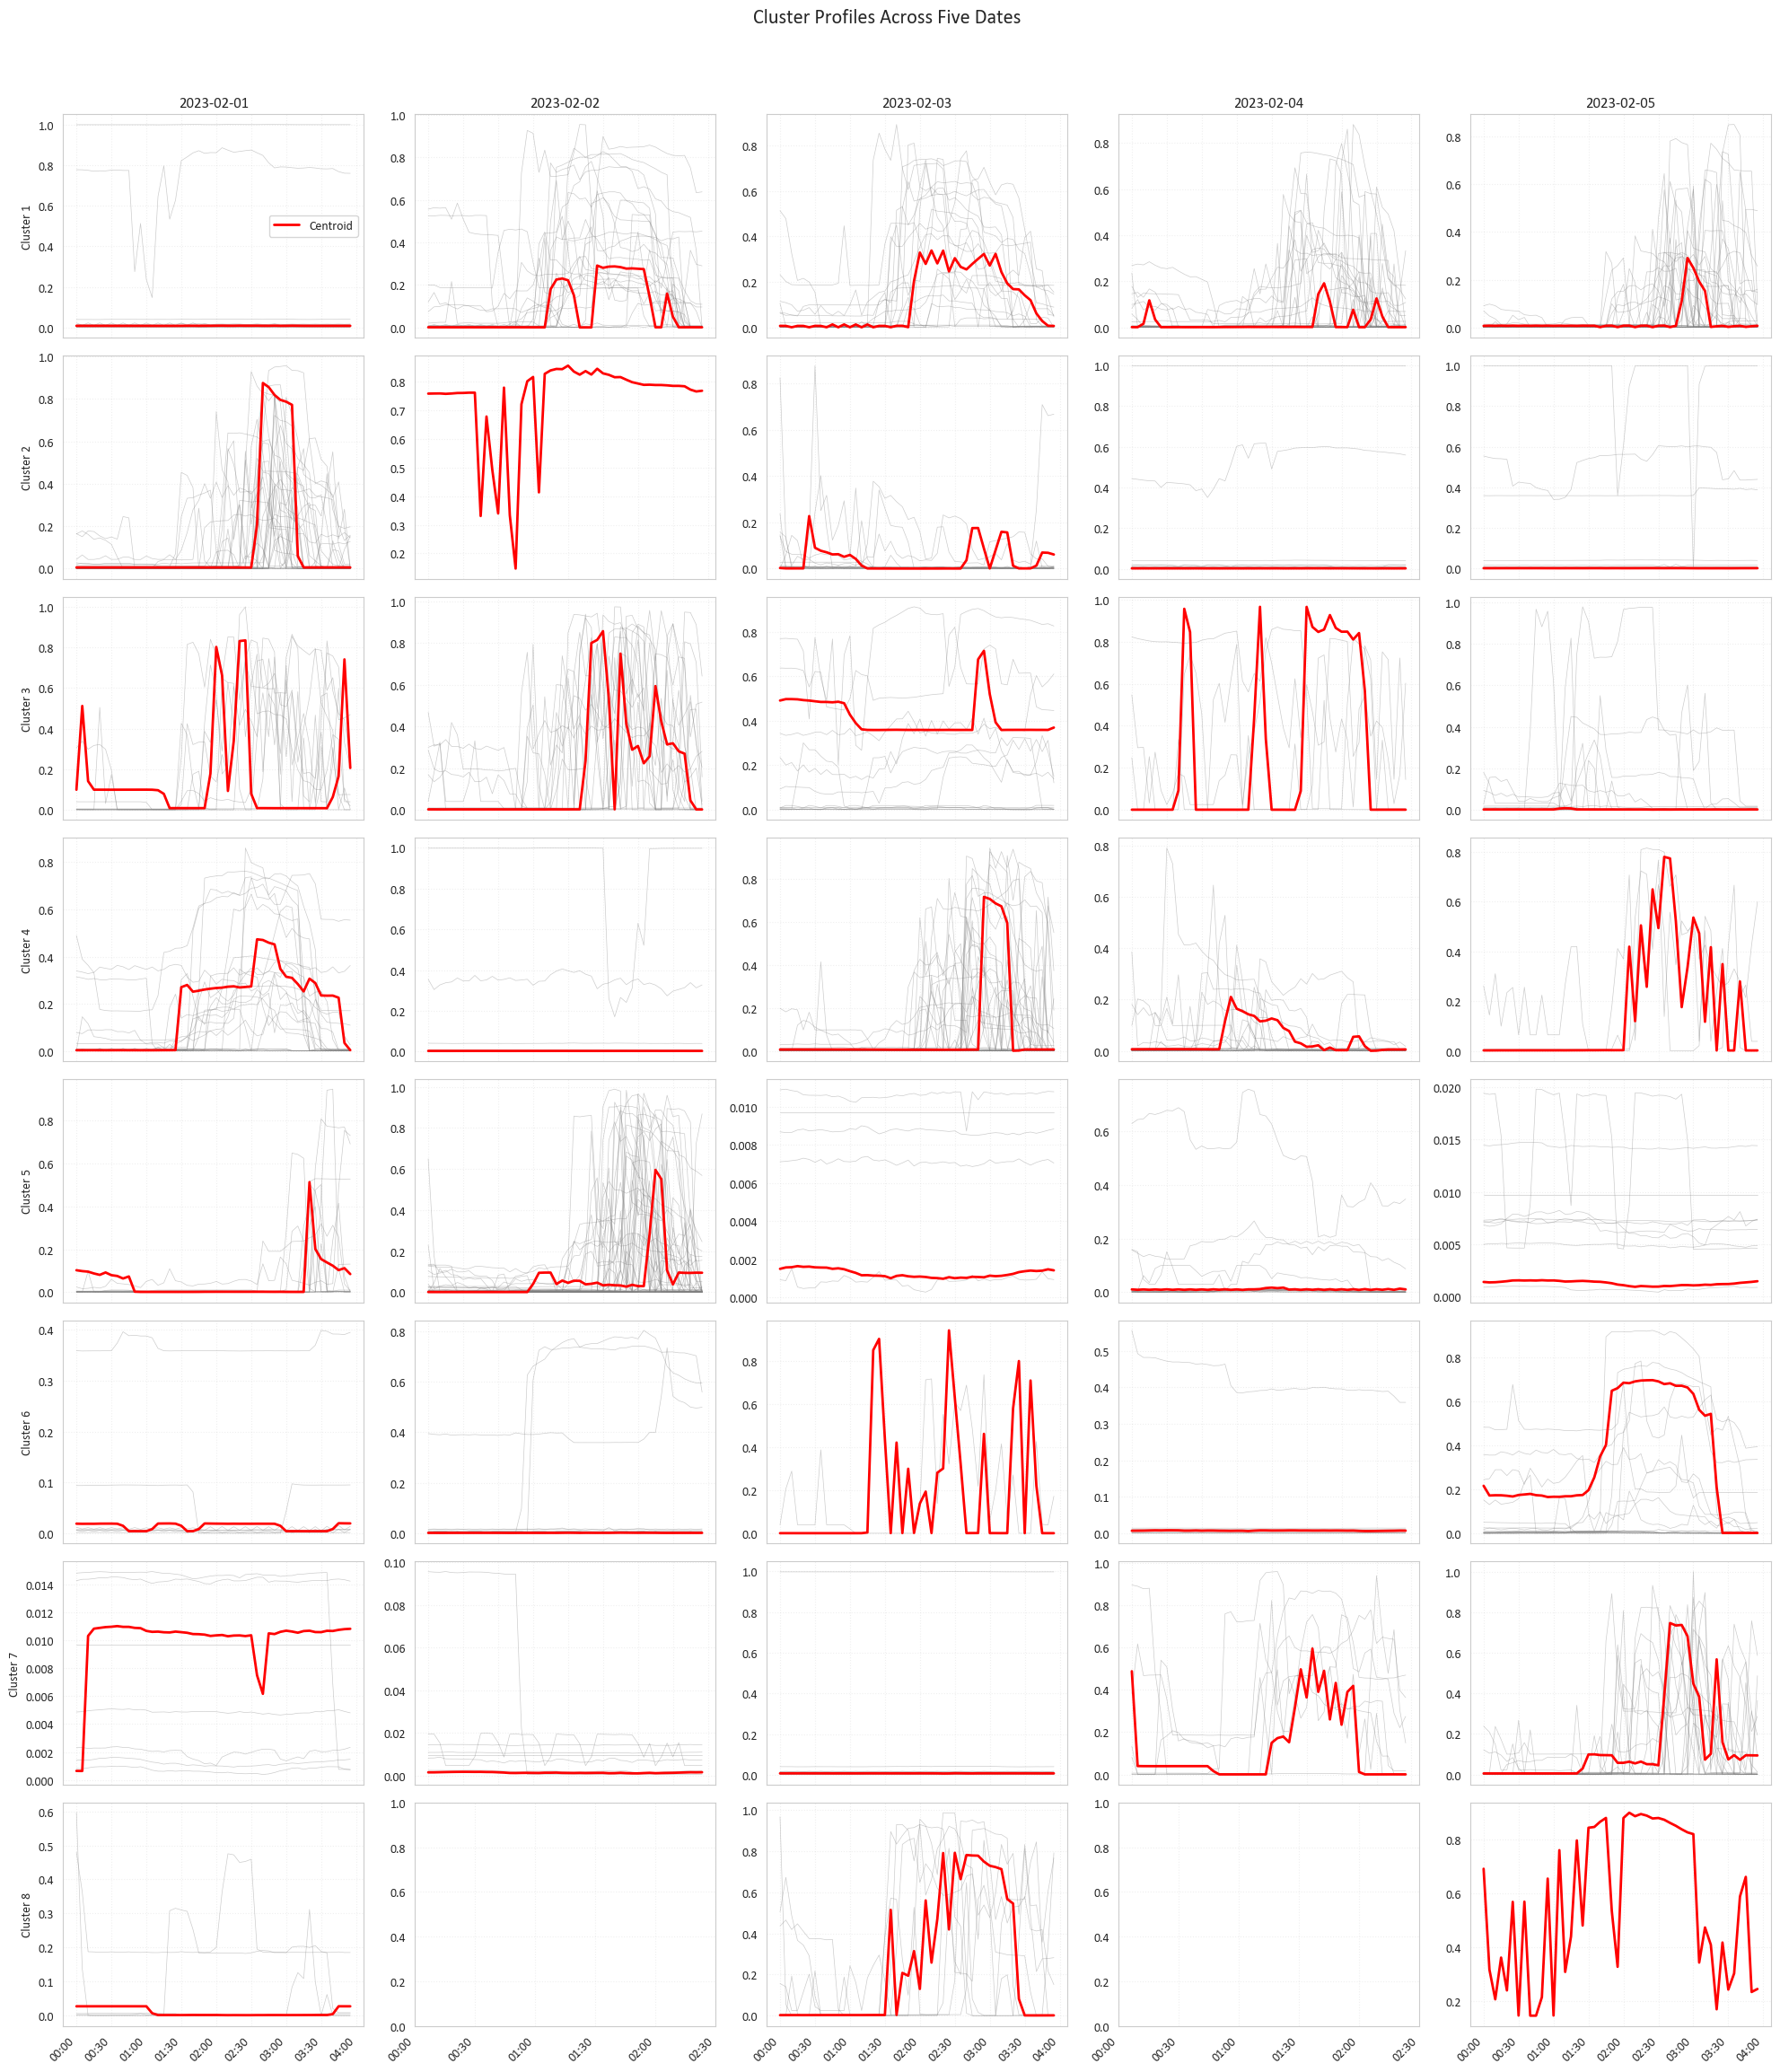

In [19]:

importlib.reload(cluster_grid)
selected_dates = ['2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04', '2023-02-05']
num_clusters = 8
# Example usage:
fig, axes = cluster_grid.visualize_cluster_grid(rlp_dict, cluster_sites_df, training_df, num_clusters, selected_dates)
plt.show()

In [20]:
#analyze cluster sizes
importlib.reload(cluster_grid)
# Example usage
result = cluster_grid.analyze_yearly_cluster_sizes(cluster_sites_df)

# Print summary statistics
print("Summary Statistics:")
for stat, value in result['summary_statistics'].items():
    print(f"{stat}: {value}")

Summary Statistics:
average_min_cluster_size: 4.50958904109589
average_max_cluster_size: 77.3972602739726
total_clusters_with_1_sites: 65
total_clusters_with_2_sites: 68
days_analyzed: 365
total_days_in_year: 365


In [86]:
importlib.reload(cluster_grid)
rlp_aggregated = cluster_grid.aggregate_rlps(rlp_dict)

In [47]:
print(rlp_aggregated.head(2))

       2023-01-01_C1  2023-01-01_C2  2023-01-01_C3  2023-01-01_C4  \
00:00       0.030238       0.009858       0.012479       0.038514   
00:30       0.018697       0.433994       0.012342       0.038529   

       2023-01-01_C5  2023-01-01_C6  2023-01-01_C7  2023-01-01_C8  \
00:00       0.034035       0.001922       0.000928       0.072141   
00:30       0.034109       0.001909       0.000842       0.012546   

       2023-01-01_C0  2023-01-02_C1  ...  2023-12-30_C0  2023-12-31_C1  \
00:00       0.003377       0.000000  ...       0.004263       0.003980   
00:30       0.003363       0.008547  ...       0.004234       0.003984   

       2023-12-31_C2  2023-12-31_C3  2023-12-31_C4  2023-12-31_C5  \
00:00       0.033234       0.503727       0.000524       0.241143   
00:30       0.033256       0.506784       0.000521       0.239984   

       2023-12-31_C6  2023-12-31_C7  2023-12-31_C8  2023-12-31_C0  
00:00       0.086594       0.071820            0.0       0.004484  
00:30       0.073

PROGRESS: 

So far, what we have are the clusters for each day and we have extracted the RLPs for each cluster in each day. 
Input going forward will be the RLPs. 

NEXT STEP:
0. Find the optimal number of clusters for the RLPs 
1. Clustering of the RLPs 
2. Determine if sub-clustering is necessary

In [62]:
# finding the best number of profile classes

importlib.reload(cp)

cluster_type = "kmeans"
min_clusters = 5
max_clusters = 15
cluster_results, best_clusters, Profile_Classes = cp.compare_cluster_sizes(rlp_dict, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
cp.print_cluster_comparison_report(cluster_results, best_clusters)



Evaluating 5 clusters...
Evaluating 6 clusters...
Evaluating 7 clusters...
Evaluating 8 clusters...
Evaluating 9 clusters...
Evaluating 10 clusters...
Evaluating 11 clusters...
Evaluating 12 clusters...
Evaluating 13 clusters...
Evaluating 14 clusters...
Evaluating 15 clusters...

=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
    Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
5             0.3607                1.3116               1.1926          1.5642              1.0                  1.0      11.0                  1.0
6             0.3529                1.4093               1.1726          1.6525              4.0                  2.0      10.0                  5.0
7             0.3462                1.4565               1.1380          1.6576              5.0                  5.0       8.0                  6.0
8             0.356

In [44]:
#cluster_results.to_csv(os.path.join(base_directory, 'optimal_profile_class_number_results.csv'), index=True)

In [63]:
print(best_clusters['Combined Index'])

5


(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Household Air Conditioner Electricity Consumption (Scaled)'>)

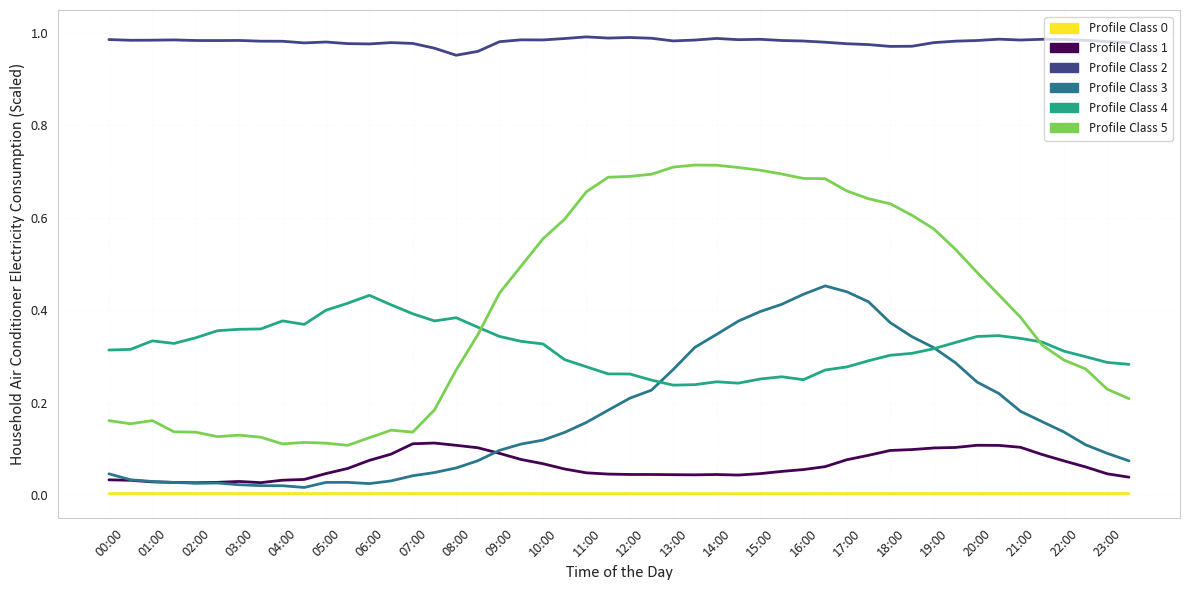

In [64]:
importlib.reload(cp)
cp.visualize_profile_classes(rlp_aggregated, Profile_Classes, best_clusters['Combined Index'])


Profile Class Sizes:
-------------------
Profile Class 0.0: 365 members
Profile Class 1.0: 1080 members
Profile Class 2.0: 336 members
Profile Class 3.0: 459 members
Profile Class 4.0: 497 members
Profile Class 5.0: 216 members


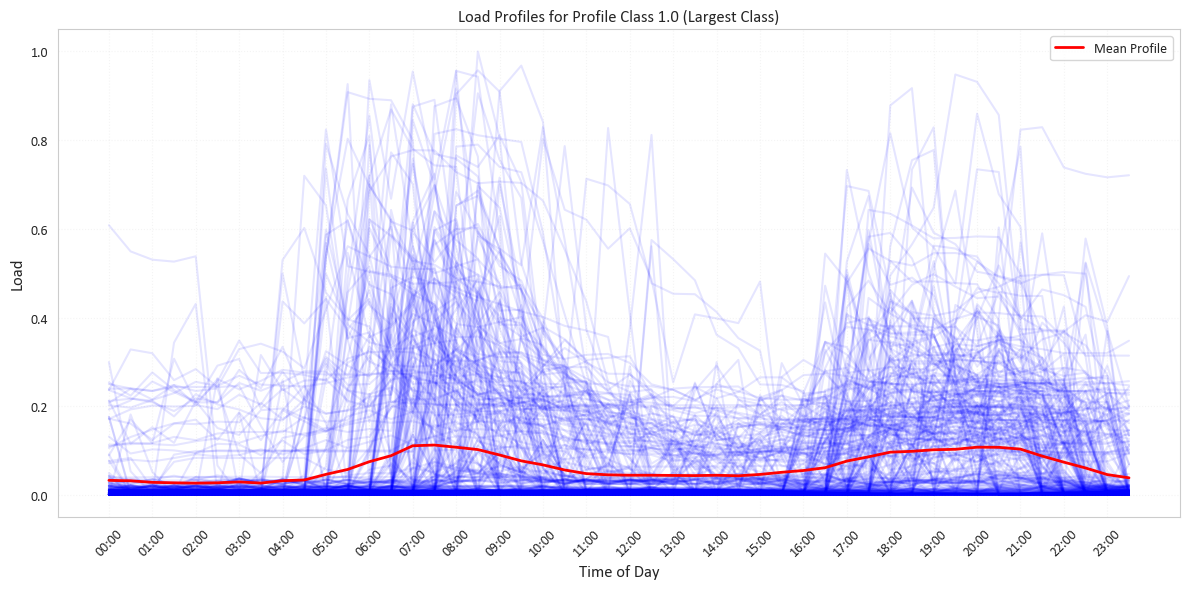

In [65]:
# Usage example:
importlib.reload(cp)
class_sizes, fig = cp.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [91]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# drop sites from cluster_sites_df where site_ID is not in training_df columns
cluster_sites_df = cluster_sites_df[cluster_sites_df['site_ID'].isin(training_df.columns)]

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
prelim_PC_assignments = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')
# Reindex with the full date range
prelim_PC_assignments = prelim_PC_assignments.reindex(date_range)

for i in prelim_PC_assignments.columns:      
    prelim_PC_assignments[[i]] = prelim_PC_assignments[[i]].astype('Int64')

print(prelim_PC_assignments)


site_ID     S0083  S0089  S0107  S0110  S0111  S0173  S0177  S0188  S0199  \
2023-01-01      1      0      3      3      0      1      0      1      0   
2023-01-02      0      0      3      0      0      0      0      3      0   
2023-01-03      0      0      0      5      1      0      0      3      3   
2023-01-04      1      0      0      0      1      1      0      1      1   
2023-01-05      1      0      0      0      1      1      1      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2023-12-27      1      0      0      0      0      0      0      3      3   
2023-12-28      0      0      0      0      1      0      0      3      3   
2023-12-29      0      0      0      0      1      0      0      3      1   
2023-12-30      0      0      0      0      0      0      0      4      0   
2023-12-31      0      0      0      0      1      1      1      5      1   

site_ID     S0208  ...  W0325  W0326  W0332  W0334  W0336  W0341  W0342  \


In [92]:
#if it doesn't exist already, export final_df


csv_path = 'prelim_profile_class_assignments.csv'
if not os.path.exists(csv_path):
    prelim_PC_assignments.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')


File written: prelim_profile_class_assignments.csv


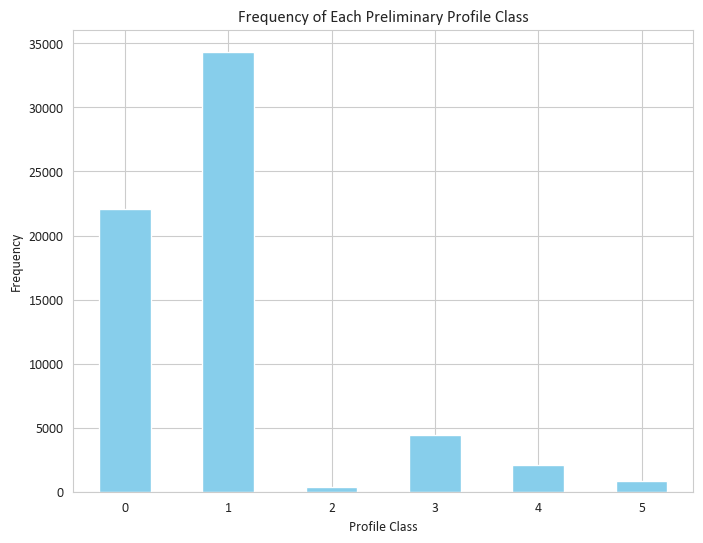

In [93]:
# Create figure of how many observations belong in each profile class 
frequency_counts = prelim_PC_assignments.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Preliminary Profile Class')
plt.xticks(rotation=0)
plt.show()

In [94]:
# merge cleaned survey with survey with station 
cleaned_survey = survey_data
survey_with_station = pd.read_csv(os.path.join(base_directory, 'survey/survey_with_station.csv'))
survey_raw = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_raw.csv'))
# merge weather station number from survey_with_station to cleaned_survey by site_ID
cleaned_survey = cleaned_survey.merge(survey_with_station[['edp_site_id', 'weather_station_number']], on='edp_site_id', how='left')
cleaned_survey = cleaned_survey.merge(survey_raw[['edp_site_id', 'num_rooms_aircon']], on='edp_site_id', how='left')
#cleaned_survey.to_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'), index=False)
# had to go and then manually clean values for num_rooms_aircon

In [95]:
cleaned_survey = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'))
# print unique num_rooms_aircon values of cleaned_survey
print(cleaned_survey['num_rooms_aircon'].unique())

[ 1  8  7  2  6  3  4  5  9 11 12 10]


In [97]:


importlib.reload(cp)

survey_df = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_cleaned_w_stations.csv'))  # Change this to your output directory
survey_df.rename(columns={'edp_site_id': 'site_ID'}, inplace=True)

weather_folder_path = os.path.join(base_directory, 'weather/bom_data_max_min')  # Change this to your output directory
# Run the merger
result_df, incomplete_stations = cp.merge_site_weather_data(prelim_PC_assignments, survey_df, weather_folder_path)

print(incomplete_stations)

# if it doesn't exist already, export to csv

csv_path = 'df_for_regression_training_weather.csv'
if not os.path.exists(csv_path):
    result_df.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')



{}
File written: df_for_regression_training_weather.csv


Final Outputs from this script:
- df_for_regression_training_weather.csv
- prelim_profile_class_assignments.csv
Next Step is to go to the Sub-Clustering Script 